# Modeling and Simulation in Python

Experiments with different ODE solvers

Copyright 2019 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
def check_system(system, slope_func):
    """

    :param system:
    :param slope_func:
    :return:
    """
    # make sure `system` contains `init`
    if not hasattr(system, 'init'):
        msg = """It looks like `system` does not contain `init`
                 as a system variable.  `init` should be a State
                 object that specifies the initial condition:"""
        raise ValueError(msg)

    # make sure `system` contains `t_end`
    if not hasattr(system, 't_end'):
        msg = """It looks like `system` does not contain `t_end`
                 as a system variable.  `t_end` should be the
                 final time:"""
        raise ValueError(msg)

    # the default value for t_0 is 0
    t_0 =  getattr(system, 't_0', 0)

    # try running the slope function with the initial conditions
    try:
        slope_func(system.init, t_0, system)
    except Exception as e:
        msg = """Before running the ODE solver, I tried
                 running the slope function you provided with the
                 initial conditions in `system` and `t=t_0` and I got
                 the following error:"""
        logger.error(msg)
        raise(e)


def run_euler(system, slope_func, **options):
    """Computes a numerical solution to a differential equation.

    `system` must contain `init` with initial conditions,
     and `t_end` with the end time.

     `system` may contain `t_0` to override the default, 0

    It can contain any other parameters required by the slope function.

    `options` can be ...

    system: System object
    slope_func: function that computes slopes

    returns: TimeFrame
    """
    check_system(system, slope_func)

    # the default value for t_0 is 0
    t_0 =  getattr(system, 't_0', 0)

    # get the initial conditions
    init, t_end, dt = system.init, system.t_end, system.dt

    # make the TimeFrame
    frame = TimeFrame(columns=init.index)
    frame.row[0] = init
    ts = linrange(t_0, t_end, dt) * get_units(t_end)
    
    event_func = options.get('events', None)
    z1 = np.nan
    
    def project(t1, y1, slopes, dt):
        k = [slope * dt for slope in slopes]
        t2 = t1 + dt
        y2 = y1 + k
        return t2, y2
    
    # run the solver
    for t1 in ts:
        y1 = frame.row[t1]
        slopes = slope_func(y1, t1, system)
        
        t2, y2 = project(t1, y1, slopes, dt)
        
        if event_func:
            z2 = event_func(y2, t2, system)
            if z1*z2 < 0:
                print(t1, z1, z2, 'event!')
                new_dt = dt * z1 / (z1 - z2)
                t2, y2 = project(t1, y1, slopes, new_dt)
                frame.row[t2] = y2
                break
            else:
                z1 = z2

        frame.row[t2] = y2

    details = ModSimSeries(dict(message='Success'))
    return frame, details


def run_ralston(system, slope_func, **options):
    """Computes a numerical solution to a differential equation.

    `system` must contain `init` with initial conditions,
     and `t_end` with the end time.

     `system` may contain `t_0` to override the default, 0

    It can contain any other parameters required by the slope function.

    `options` can be ...

    system: System object
    slope_func: function that computes slopes

    returns: TimeFrame
    """
    check_system(system, slope_func)

    # the default value for t_0 is 0
    t_0 =  getattr(system, 't_0', 0)

    # get the initial conditions
    init, t_end, dt = system.init, system.t_end, system.dt

    # make the TimeFrame
    frame = TimeFrame(columns=init.index)
    frame.row[0] = init
    ts = linrange(t_0, t_end, dt) * get_units(t_end)
    
    event_func = options.get('events', None)
    z1 = np.nan
    
    def project(t1, y1, slopes, dt):
        k = [slope * dt for slope in slopes]
        t2 = t1 + dt
        y2 = y1 + k
        return k, t2, y2
    
    # run the solver
    for t1 in ts:
        y1 = frame.row[t1]
        
        slopes = slope_func(y1, t1, system)
        k1 = [slope * dt for slope in slopes]
        k1 = np.asarray(k1)
        t_mid = t1 + 2*dt/3
        y_mid = y1 + 2*k1/3
        
        slopes = slope_func(y_mid, t_mid, system)
        k2 = [slope * dt for slope in slopes]
        k2 = np.asarray(k2)        
        
        k = (3*k2 + k1) / 4
        t2 = t1 + dt
        y2 = y1 + k

        if event_func:
            z2 = event_func(y2, t2, system)
            if z1*z2 < 0:
                scale = magnitude(z1 / (z1 - z2))
                t2 = t1 + scale * dt
                y2 = y1 + scale * k
                frame.row[t2] = y2
                #TODO: change message
                break
            else:
                z1 = z2

        frame.row[t2] = y2

    details = ModSimSeries(dict(message='Success'))
    return frame, details

### Dropping pennies

I'll start by getting the units we need from Pint.

In [3]:
m = UNITS.meter
s = UNITS.second

<Unit('second')>

And defining the initial state.

In [4]:
init = State(y=381 * m, 
             v=0 * m/s)

,values
y,381 meter
v,0.0 meter / second


Acceleration due to gravity is about 9.8 m / s$^2$.

In [5]:
g = 9.8 * m/s**2

9.8 <Unit('meter / second ** 2')>

When we call `odeint`, we need an array of timestamps where we want to compute the solution.

I'll start with a duration of 10 seconds.

In [6]:
t_end = 10 * s

10 <Unit('second')>

Now we make a `System` object.

In [7]:
system = System(init=init, g=g, t_end=t_end)

,values
init,y 381 meter v 0.0 meter / secon...
g,9.8 meter / second ** 2
t_end,10 second


And define the slope function.

In [8]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    y, v = state
    g = system.g    

    dydt = v
    dvdt = -g
    
    return dydt, dvdt

It's always a good idea to test the slope function with the initial conditions.

In [9]:
dydt, dvdt = slope_func(system.init, 0, system)
print(dydt)
print(dvdt)

0.0 meter / second
-9.8 meter / second ** 2


Now we're ready to call `run_ode_solver`

In [10]:
system.set(dt=0.1*s)
results, details = run_euler(system, slope_func, max_step=0.5)
details.message

'Success'

In [11]:
results

,y,v
0.0,381 meter,0.0 meter / second
0.1,381.0 meter,-0.9800000000000001 meter / second
0.2,380.902 meter,-1.9600000000000002 meter / second
0.3,380.70599999999996 meter,-2.9400000000000004 meter / second
0.4,380.412 meter,-3.9200000000000004 meter / second
0.5,380.02 meter,-4.9 meter / second
0.6,379.53 meter,-5.880000000000001 meter / second
0.7,378.94199999999995 meter,-6.860000000000001 meter / second
0.8,378.256 meter,-7.840000000000002 meter / second
0.9,377.472 meter,-8.820000000000002 meter / second


In [12]:
def crossings(series, value):
    """Find the labels where the series passes through value.

    The labels in series must be increasing numerical values.

    series: Series
    value: number

    returns: sequence of labels
    """
    units = get_units(series.values[0])
    values = magnitudes(series - value)
    interp = InterpolatedUnivariateSpline(series.index, values)
    return interp.roots()

In [13]:
t_crossings = crossings(results.y, 0)

array([8.86802711])

In [14]:
system.set(dt=0.1*s)
results, details = run_ralston(system, slope_func, max_step=0.5)
details.message

'Success'

In [15]:
t_crossings = crossings(results.y, 0)

array([8.81788535])

Here are the results:

In [16]:
results

,y,v
0.0,381 meter,0.0 meter / second
0.1,380.951 meter,-0.9800000000000001 meter / second
0.2,380.80400000000003 meter,-1.9600000000000002 meter / second
0.3,380.559 meter,-2.9400000000000004 meter / second
0.4,380.216 meter,-3.9200000000000004 meter / second
0.5,379.77500000000003 meter,-4.9 meter / second
0.6,379.23600000000005 meter,-5.880000000000001 meter / second
0.7,378.59900000000005 meter,-6.860000000000001 meter / second
0.8,377.86400000000003 meter,-7.840000000000002 meter / second
0.9,377.031 meter,-8.820000000000002 meter / second


And here's position as a function of time:

Saving figure to file figs/chap09-fig01.pdf


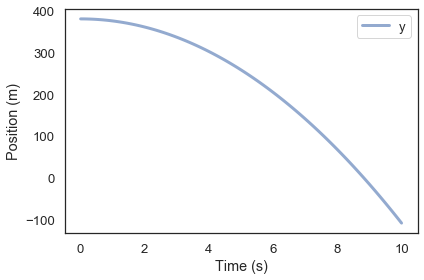

In [17]:
def plot_position(results):
    plot(results.y, label='y')
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')

plot_position(results)
savefig('figs/chap09-fig01.pdf')

### Onto the sidewalk

To figure out when the penny hit the sidewalk, we can use `crossings`, which finds the times where a `Series` passes through a given value.

In [18]:
def crossings(series, value):
    """Find the labels where the series passes through value.

    The labels in series must be increasing numerical values.

    series: Series
    value: number

    returns: sequence of labels
    """
    units = get_units(series.values[0])
    values = magnitudes(series - value)
    interp = InterpolatedUnivariateSpline(series.index, values)
    return interp.roots()

In [19]:
t_crossings = crossings(results.y, 0)

array([8.81788535])

For this example there should be just one crossing, the time when the penny hits the sidewalk.

In [20]:
t_sidewalk = t_crossings[0] * s

8.81788534972054 <Unit('second')>

We can compare that to the exact result.  Without air resistance, we have

$v = -g t$

and

$y = 381 - g t^2 / 2$

Setting $y=0$ and solving for $t$ yields

$t = \sqrt{\frac{2 y_{init}}{g}}$

In [21]:
sqrt(2 * init.y / g)

8.817885349720552 <Unit('second')>

The estimate is accurate to about 10 decimal places.

## Events

Instead of running the simulation until the penny goes through the sidewalk, it would be better to detect the point where the penny hits the sidewalk and stop.  `run_ode_solver` provides exactly the tool we need, **event functions**.

Here's an event function that returns the height of the penny above the sidewalk:

In [22]:
def event_func(state, t, system):
    """Return the height of the penny above the sidewalk.
    """
    y, v = state
    return y

And here's how we pass it to `run_ode_solver`.  The solver should run until the event function returns 0, and then terminate.

In [23]:
results, details = run_ralston(system, slope_func, events=event_func)
details

,values
message,Success


The message from the solver indicates the solver stopped because the event we wanted to detect happened.

Here are the results:

In [24]:
results

,y,v
0.000000,381 meter,0.0 meter / second
0.100000,380.951 meter,-0.9800000000000001 meter / second
0.200000,380.80400000000003 meter,-1.9600000000000002 meter / second
0.300000,380.559 meter,-2.9400000000000004 meter / second
0.400000,380.216 meter,-3.9200000000000004 meter / second
0.500000,379.77500000000003 meter,-4.9 meter / second
0.600000,379.23600000000005 meter,-5.880000000000001 meter / second
0.700000,378.59900000000005 meter,-6.860000000000001 meter / second
0.800000,377.86400000000003 meter,-7.840000000000002 meter / second
0.900000,377.031 meter,-8.820000000000002 meter / second


With the `events` option, the solver returns the actual time steps it computed, which are not necessarily equally spaced. 

The last time step is when the event occurred:

In [25]:
t_sidewalk = get_last_label(results) * s

8.81780237518735 <Unit('second')>

The result is accurate to about 15 decimal places.

We can also check the velocity of the penny when it hits the sidewalk:

In [26]:
v_sidewalk = get_last_value(results.v)

-86.41446327683617 <Unit('meter / second')>

And convert to kilometers per hour.

In [27]:
km = UNITS.kilometer
h = UNITS.hour
v_sidewalk.to(km / h)

-311.09206779661025 <Unit('kilometer / hour')>

If there were no air resistance, the penny would hit the sidewalk (or someone's head) at more than 300 km/h.

So it's a good thing there is air resistance.

### Code from the previous chapter

Read the data.

In [28]:
data = pd.read_csv('data/glucose_insulin.csv', index_col='time');

Interpolate the insulin data.

In [29]:
I = interpolate(data.insulin)

Initialize the parameters

In [30]:
G0 = 290
k1 = 0.03
k2 = 0.02
k3 = 1e-05

1e-05

To estimate basal levels, we'll use the concentrations at `t=0`.

In [31]:
Gb = data.glucose[0]
Ib = data.insulin[0]

11

Create the initial condtions.

In [32]:
init = State(G=G0, X=0)

,values
G,290
X,0


Make the `System` object.

In [33]:
t_0 = get_first_label(data)
t_end = get_last_label(data)

182

In [34]:
system = System(G0=G0, k1=k1, k2=k2, k3=k3,
                init=init, Gb=Gb, Ib=Ib, I=I,
                t_0=t_0, t_end=t_end, dt=2)

,values
G0,290
k1,0.03
k2,0.02
k3,1e-05
init,G 290 X 0 dtype: int64
Gb,92
Ib,11
I,<scipy.interpolate.interpolate.interp1d object...
t_0,0
t_end,182


In [35]:
def update_func(state, t, system):
    """Updates the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: State object
    """
    G, X = state
    k1, k2, k3 = system.k1, system.k2, system.k3 
    I, Ib, Gb = system.I, system.Ib, system.Gb
    dt = system.dt
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

In [36]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

In [37]:
%time results = run_simulation(system, update_func);

CPU times: user 174 ms, sys: 84 µs, total: 174 ms
Wall time: 172 ms


In [38]:
results

,G,X
0,290,0
2,278.12,0
4,266.953,0.0003
6,256.295,0.002668
8,245.07,0.00404128
10,233.905,0.00467963
12,223.202,0.00525244
14,212.985,0.00572235
16,203.288,0.00609345
18,194.133,0.00632971


### Numerical solution

In the previous chapter, we approximated the differential equations with difference equations, and solved them using `run_simulation`.

In this chapter, we solve the differential equation numerically using `run_ode_solver`, which is a wrapper for the SciPy ODE solver.

Instead of an update function, we provide a slope function that evaluates the right-hand side of the differential equations.  We don't have to do the update part; the solver does it for us.

In [39]:
def slope_func(state, t, system):
    """Computes derivatives of the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: derivatives of G and X
    """
    G, X = state
    k1, k2, k3 = system.k1, system.k2, system.k3 
    I, Ib, Gb = system.I, system.Ib, system.Gb
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

We can test the slope function with the initial conditions.

In [40]:
slope_func(init, 0, system)

(-5.9399999999999995, 0.0)

Here's how we run the ODE solver.

In [41]:
system = System(G0=G0, k1=k1, k2=k2, k3=k3,
                init=init, Gb=Gb, Ib=Ib, I=I,
                t_0=t_0, t_end=t_end, dt=1)

%time results2, details = run_ralston(system, slope_func)

CPU times: user 478 ms, sys: 3.01 ms, total: 481 ms
Wall time: 478 ms


`results` is a `TimeFrame` with one row for each time step and one column for each state variable:

In [42]:
results2

,G,X
0,290,0
1,284.149,3.75e-05
2,278.45,0.000148507
3,272.88,0.000554067
4,267.299,0.0014664
5,261.584,0.00250296
6,255.817,0.00329625
7,250.07,0.00387859
8,244.395,0.00428109
9,238.835,0.00458733


Plotting the results from `run_simulation` and `run_ode_solver`, we can see that they are not very different.

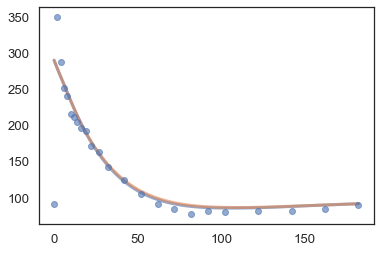

In [43]:
plot(results.G, '-')
plot(results2.G, '-')
plot(data.glucose, 'bo')

The differences in `G` are less than 1%.

In [44]:
diff = results.G - results2.G
percent_diff = diff / results2.G * 100

max(abs(percent_diff.dropna()))

1.895692587096462

In [45]:
stop

NameError: name 'stop' is not defined

**Exercise:** How sensitive are the results to the starting guess for the parameters?  If you try different values for the starting guess, do we get the same values for the best parameters?

**Related reading:** You might be interested in this article about [people making a DIY artificial pancreas](https://www.bloomberg.com/news/features/2018-08-08/the-250-biohack-that-s-revolutionizing-life-with-diabetes).

In [ ]:
%matplotlib inline

import numpy as np
from RungeKutta import DormandPrince

def f(u, t):
    """2x2 system for a van der Pool oscillator."""
    return [u[1], 3.*(1. - u[0]*u[0])*u[1] - u[0]]


solver = DormandPrince(f, rtol=0.0, atol=1e-6)
solver.set_initial_condition([2.0, 0.0])
t_points = np.linspace(0, 30, 150)
u, t = solver.solve(t_points)

u0 = u[:,0]
from matplotlib.pyplot import *
plot(t, u0)
show()

In [ ]:
def f(u, t):
    return a*u*(1 - u/R)

a = 2
R = 1E+5
A = 1

solver = DormandPrince(f, rtol=0.0, atol=1e-6)

solver.set_initial_condition(A)

T = 20  # end of simulation
dt = 0.25
N = int(round(T/dt))
time_points = np.linspace(0, T, N+1)

tol = 100   # tolerance for termination criterion

def terminate(u, t, step_no):
    """u[step_no] holds (the most recent) solution at t[step_no]."""
    return abs(u[step_no] - R) < tol

u, t = solver.solve(time_points, terminate)
print('Final u(t=%g)=%g' % (t[-1], u[-1]))

from matplotlib.pyplot import *
plot(t, u, 'r-')
savefig('tmppng'); savefig('tmp.pdf')
show()

In [ ]:
import matplotlib.pyplot as plt

c = 1
Theta0_degrees = 30

solver = DormandPrince(f)

Theta0 = Theta0_degrees*np.pi/180

solver.set_initial_condition([0, Theta0])
# Solve for num_periods periods using formulas for small theta
freq = np.sqrt(c)          # frequency of oscillations
period = 2*np.pi/freq      # one period
N = 40                  # intervals per period
dt = period/N           # time step
num_periods = 10
T = num_periods*period  # total simulation time

time_points = np.linspace(0, T, num_periods*N+1)
u, t = solver.solve(time_points)

# Extract components and plot theta
theta = u[:,1]
omega = u[:,0]
theta_linear = lambda t: Theta0*np.cos(np.sqrt(c)*t)
plt.plot(t, theta, t, theta_linear(t))
legend(['Euler-Cromer', 'Linearized problem'], loc='lower left')